# Developement of optimization algorithm

The past attemps of improving the computer win percentage beyound the results fitting random data sets were not successful. When using the improved computer the main problem was that the computer mainly fit the computer model but that it did not improve in more general cases.
There are not enough computer versus human to use them efficiently but possible the same problem exist also there.

Thus a new method is needed. 
The steps of it are

0) start with random model or with result from other fits? 
1) create a new computer model rather random first
later gradient methods can be used to combine past models
2) play sufficently often against existing models that win percentages are reliable enough. 

Iterate step 1 to 2 for some time, test against humans sometimes.

Do the models need a random component? Can be set easily to 0, with a paramter, the oppiste is not true, thus included.  

Steps needed:
    1) New random model which follows the same principle than the not random models need to be build.
    2) Full model or step wise?

Full means best option is predicted from a single model. 
Otherwise only each step is predicted, still needs information on the previous steps in the process. 

I decide for step wise. 

1) Is whether to take open card. Is binary, thus logistic function used. Parameters, for now minumum amount no chance to consider vanishing card for now:
    value_open_card, sum_own, own_n_closed, sum_other, other_n_closed
2) (Is not always applied) Is whether to take previously closed card: Is binary, thus logistic function used. Parameters, for now minumum amount no chance to consider vanishing card for now:
    value_closed_card, sum_own, own_n_closed, sum_other, other_n_closed
3) which own card to give if not random trun which is random, is numeric, options are the cards available and closed cards, depends on available cards, in particular the largest value, when that is used exclusively of the open one, it gets a binary problem, again logistic, parameters: Value of_exchangable_card, max_own, sum_own, own_n_closed, sum_other, other_n_closed
 
 delta_score (own-other current score) would make sense for all but more difficult to add, keep it simple for now 

Means that random is not anymore random here but more clever but fine as start.

In [1]:
import numpy as np
import random as random
import scipy
#using simpleguitk for display, is not needed for computer game
import simpleguitk as simplegui
import time
#new ones
import pandas as pd
#ml methods
from xgboost import XGBRegressor
from xgboost import XGBClassifier
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import os
#skyjo game classes and functions 
from skyjo_functions4 import *
#own functions for machine learning
from ml_functions2 import *
#for plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#for confidence intervalls
from scipy.stats import beta
#for splitting
from sklearn.model_selection import train_test_split
#confusing matrix
from sklearn.metrics import confusion_matrix

Now I work on the fitting algorithm. The method is gradient fit, but it is not against a constant truth asusual but a changing model. At the beginning it is just, the all 0 model. As the first step all other parameters are separatedly changed by an arbitrary step. 

In [2]:
#means changes within the function do not have an effect outside of it , copy it to the top functions does not change anything 
def first_gradient_step(open_steps,discard_steps,value_steps,realizations):
    n_it=realizations
    results=np.zeros((40,19))
    for j in range(results.shape[1]):
        print(f"doing case {j}")
        level20_open_variable=np.zeros((6))
        level20_discard_variable=np.zeros((6))
        level20_value_variable=np.zeros((7))
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        if j<6:
            level21_open_variable[j]=open_steps[j]
        elif j<12:
            level21_discard_variable[j-6]=discard_steps[j-6]
        else:
            level21_value_variable[j-12]=value_steps[j-12]    
        print(level21_open_variable,level21_discard_variable,level21_value_variable)
        results[0:6,j]=level20_open_variable
        results[6:12,j]=level20_discard_variable
        results[12:19,j]=level20_value_variable    
        results[19:25,j]=level21_open_variable
        results[25:31,j]=level21_discard_variable
        results[31:38,j]=level21_value_variable         
        win20=0
        start_time=time.time()
        for i in range(n_it):
            names=['alpha','beta']
            nature=['computer','computer']
            levels=[20,21]
            winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
            if winner[0]==1:
                win20+=1
        results[38,j]=n_it
        results[39,j]=win20
        stop_time=time.time()
        print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
        print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
    return results     

In [27]:
factors=[-0.00005,-0.0001,-0.0002,-0.0005,-0.001,-0.002,-0.005,-0.01,-0.02,-0.05,-0.1]
for i in range(len(factors)):
    print(f"doing factor {factors[i]}")
    open_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    discard_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    value_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    #does not recreated levls good 
    result=first_gradient_step(open_step,discard_step,value_step,400)
    np.savetxt("gradient_level20_vm"+str(i)+".txt",result)

doing factor -5e-05
doing case 0
[-5.e-05  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.707 seconds
level 20 won to 45.0 %
doing case 1
[ 0.e+00 -5.e-05  0.e+00  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.628 seconds
level 20 won to 50.0 %
doing case 2
[ 0.e+00  0.e+00 -5.e-05  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.47 seconds
level 20 won to 49.0 %
doing case 3
[ 0.e+00  0.e+00  0.e+00 -5.e-05  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.62 seconds
level 20 won to 50.5 %
doing case 4
[ 0.e+00  0.e+00  0.e+00  0.e+00 -5.e-05  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.127 seconds
level 20 won to 48.2 %
doing case 5
[ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -5.e-05] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.84 seconds
level 20 won to 49.0 %
doing case 6
[0. 0. 0. 0. 0. 

400 games need 22.451 seconds
level 20 won to 52.2 %
doing case 13
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.     -0.0002  0.      0.      0.      0.      0.    ]
400 games need 21.956 seconds
level 20 won to 48.2 %
doing case 14
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.     -0.0002  0.      0.      0.      0.    ]
400 games need 21.796 seconds
level 20 won to 49.5 %
doing case 15
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.     -0.0002  0.      0.      0.    ]
400 games need 21.297 seconds
level 20 won to 61.2 %
doing case 16
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.     -0.0002  0.      0.    ]
400 games need 21.807 seconds
level 20 won to 50.5 %
doing case 17
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.      0.     -0.0002  0.    ]
400 games need 20.862 seconds
level 20 won to 57.5 %
doing case 18
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.      0.      0.     -0.0002]
400 games 

400 games need 24.202 seconds
level 20 won to 49.8 %
doing case 8
[0. 0. 0. 0. 0. 0.] [ 0.     0.    -0.002  0.     0.     0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 25.193 seconds
level 20 won to 41.5 %
doing case 9
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.    -0.002  0.     0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.484 seconds
level 20 won to 15.2 %
doing case 10
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.     0.    -0.002  0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.745 seconds
level 20 won to 41.2 %
doing case 11
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.     0.     0.    -0.002] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.914 seconds
level 20 won to 16.5 %
doing case 12
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [-0.002  0.     0.     0.     0.     0.     0.   ]
400 games need 21.812 seconds
level 20 won to 53.0 %
doing case 13
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.    -0.002  0.     0.     0.     0.     0.   ]
400 games need 20.24 seconds
level 20 won to 67.8 %
doing case 14
[0. 

400 games need 25.533 seconds
level 20 won to 41.0 %
doing case 5
[ 0.    0.    0.    0.    0.   -0.02] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 25.576 seconds
level 20 won to 38.5 %
doing case 6
[0. 0. 0. 0. 0. 0.] [-0.02  0.    0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.114 seconds
level 20 won to 30.0 %
doing case 7
[0. 0. 0. 0. 0. 0.] [ 0.   -0.02  0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 27.617 seconds
level 20 won to 32.2 %
doing case 8
[0. 0. 0. 0. 0. 0.] [ 0.    0.   -0.02  0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.844 seconds
level 20 won to 18.2 %
doing case 9
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.   -0.02  0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.598 seconds
level 20 won to 13.2 %
doing case 10
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.    0.   -0.02  0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 27.52 seconds
level 20 won to 19.2 %
doing case 11
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.    0.    0.   

Now I am loading a number and combine the in a file for plotting to find where the gradient flattens for the different parameters.

In [ ]:
gra1=np.loadtxt("gradient_level20_v1.txt")
gra2=np.loadtxt("gradient_level20_v2.txt")
gra3=np.loadtxt("gradient_level20_v3.txt")
gra4=np.loadtxt("gradient_level20_v4.txt")
gra5=np.loadtxt("gradient_level20_v5.txt")
gra6=np.loadtxt("gradient_level20_v6.txt")
gra7=np.loadtxt("gradient_level20_v7.txt")
gra8=np.loadtxt("gradient_level20_v8.txt")
gra9=np.loadtxt("gradient_level20_v9.txt")
gra10=np.loadtxt("gradient_level20_v10.txt")
gra11=np.loadtxt("gradient_level20_v11.txt")
gra12=np.loadtxt("gradient_level20_v12.txt")
gra13=np.loadtxt("gradient_level20_v13.txt")
gra14=np.loadtxt("gradient_level20_v14.txt")
compp=np.zeros((20,14))
compp[0,:]=np.array([1,0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001,0.00005])
compp[1:20,0]=gra1[39,:]/gra1[38,:]
compp[1:20,1]=gra2[39,:]/gra2[38,:]
compp[1:20,2]=gra3[39,:]/gra3[38,:]
compp[1:20,3]=gra4[39,:]/gra4[38,:]
compp[1:20,4]=gra5[39,:]/gra5[38,:]
compp[1:20,5]=gra6[39,:]/gra6[38,:]
compp[1:20,6]=gra7[39,:]/gra7[38,:]
compp[1:20,7]=gra8[39,:]/gra8[38,:]
compp[1:20,8]=gra9[39,:]/gra9[38,:]
compp[1:20,9]=gra10[39,:]/gra10[38,:]
compp[1:20,10]=gra11[39,:]/gra11[38,:]
compp[1:20,11]=gra12[39,:]/gra12[38,:]
compp[1:20,12]=gra13[39,:]/gra13[38,:]
compp[1:20,13]=gra14[39,:]/gra14[38,:]

Text(0.5, 1.0, 'against equal probability case')

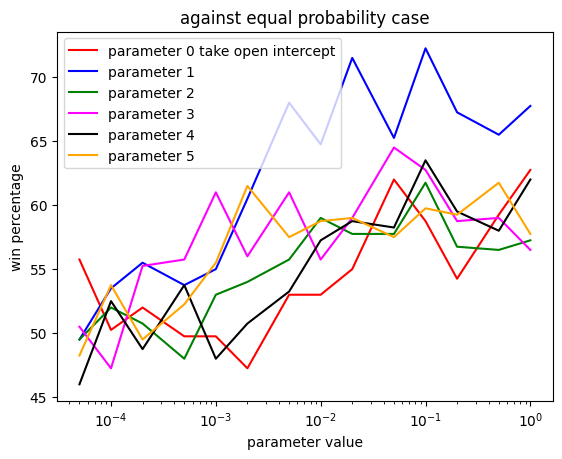

In [42]:


plt.plot(compp[0,:],100*compp[1,:],color='red',label='parameter 0 take open intercept') 
plt.plot(compp[0,:],100*compp[2,:],color='blue',label='parameter 1') 
plt.plot(compp[0,:],100*compp[3,:],color='green',label='parameter 2') 
plt.plot(compp[0,:],100*compp[4,:],color='magenta',label='parameter 3') 
plt.plot(compp[0,:],100*compp[5,:],color='black',label='parameter 4')  
plt.plot(compp[0,:],100*compp[6,:],color='orange',label='parameter 5')  
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("against equal probability case")

Text(0.5, 1.0, 'against equal probability case')

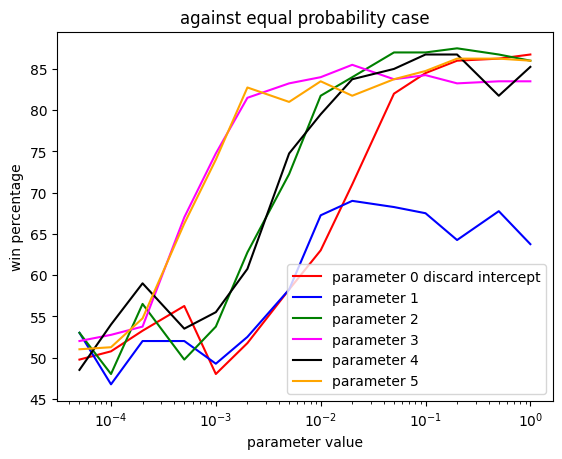

In [43]:
plt.plot(compp[0,:],100*compp[7,:],color='red',label='parameter 0 discard intercept') 
plt.plot(compp[0,:],100*compp[8,:],color='blue',label='parameter 1') 
plt.plot(compp[0,:],100*compp[9,:],color='green',label='parameter 2') 
plt.plot(compp[0,:],100*compp[10,:],color='magenta',label='parameter 3') 
plt.plot(compp[0,:],100*compp[11,:],color='black',label='parameter 4')  
plt.plot(compp[0,:],100*compp[12,:],color='orange',label='parameter 5')  
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("against equal probability case")

Text(0.5, 1.0, 'against equal probability case')

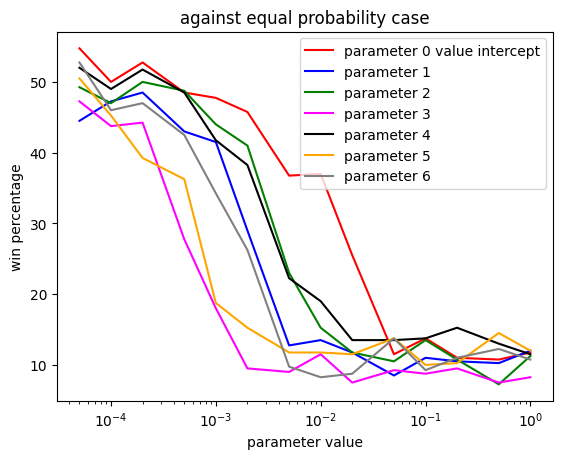

In [44]:
plt.plot(compp[0,:],100*compp[13,:],color='red',label='parameter 0 value intercept') 
plt.plot(compp[0,:],100*compp[14,:],color='blue',label='parameter 1') 
plt.plot(compp[0,:],100*compp[15,:],color='green',label='parameter 2') 
plt.plot(compp[0,:],100*compp[16,:],color='magenta',label='parameter 3') 
plt.plot(compp[0,:],100*compp[17,:],color='black',label='parameter 4')  
plt.plot(compp[0,:],100*compp[18,:],color='orange',label='parameter 5')  
plt.plot(compp[0,:],100*compp[19,:],color='gray',label='parameter 6') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("against equal probability case")

It flattened always at most at 0.1.

Now the same for negative values of parameters. First collecting the values. 

In [ ]:
gram1=np.loadtxt("gradient_level20_vm0.txt")
gram2=np.loadtxt("gradient_level20_vm1.txt")
gram3=np.loadtxt("gradient_level20_vm2.txt")
gram4=np.loadtxt("gradient_level20_vm3.txt")
gram5=np.loadtxt("gradient_level20_vm4.txt")
gram6=np.loadtxt("gradient_level20_vm5.txt")
gram7=np.loadtxt("gradient_level20_vm6.txt")
gram8=np.loadtxt("gradient_level20_vm7.txt")
gram9=np.loadtxt("gradient_level20_vm8.txt")
gram10=np.loadtxt("gradient_level20_vm9.txt")
gram11=np.loadtxt("gradient_level20_vm10.txt")
compm=np.zeros((20,11))
compm[0,:]=np.array([0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1])
compm[1:20,0]=gram1[39,:]/gram1[38,:]
compm[1:20,1]=gram2[39,:]/gram2[38,:]
compm[1:20,2]=gram3[39,:]/gram3[38,:]
compm[1:20,3]=gram4[39,:]/gram4[38,:]
compm[1:20,4]=gram5[39,:]/gram5[38,:]
compm[1:20,5]=gram6[39,:]/gram6[38,:]
compm[1:20,6]=gram7[39,:]/gram7[38,:]
compm[1:20,7]=gram8[39,:]/gram8[38,:]
compm[1:20,8]=gram9[39,:]/gram9[38,:]
compm[1:20,9]=gram10[39,:]/gram10[38,:]
compm[1:20,10]=gram11[39,:]/gram11[38,:]

Text(0.5, 1.0, 'against equal probability case')

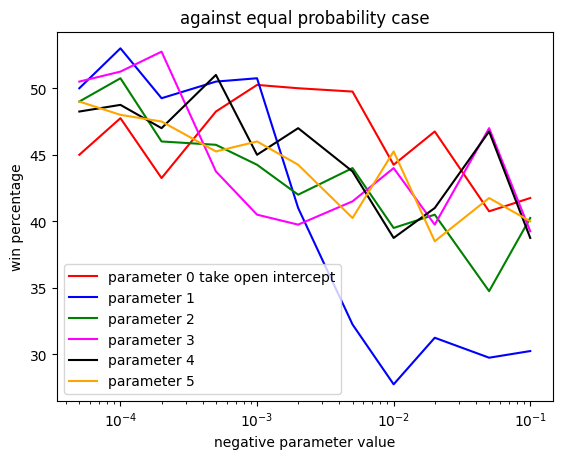

In [47]:
plt.plot(compm[0,:],100*compm[1,:],color='red',label='parameter 0 take open intercept') 
plt.plot(compm[0,:],100*compm[2,:],color='blue',label='parameter 1') 
plt.plot(compm[0,:],100*compm[3,:],color='green',label='parameter 2') 
plt.plot(compm[0,:],100*compm[4,:],color='magenta',label='parameter 3') 
plt.plot(compm[0,:],100*compm[5,:],color='black',label='parameter 4')  
plt.plot(compm[0,:],100*compm[6,:],color='orange',label='parameter 5')  
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("negative parameter value")
plt.ylabel("win percentage")
plt.title("against equal probability case")

Text(0.5, 1.0, 'against equal probability case')

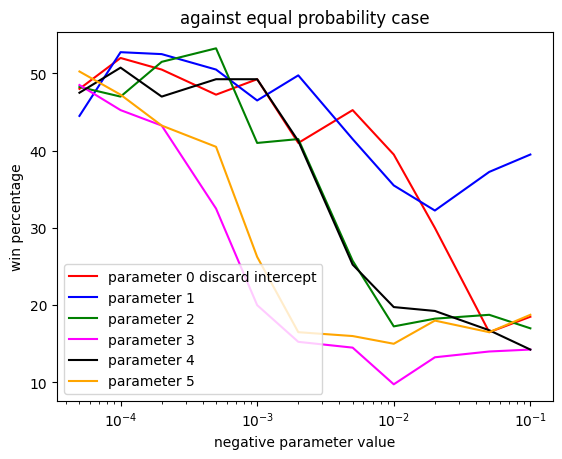

In [48]:
plt.plot(compm[0,:],100*compm[7,:],color='red',label='parameter 0 discard intercept') 
plt.plot(compm[0,:],100*compm[8,:],color='blue',label='parameter 1') 
plt.plot(compm[0,:],100*compm[9,:],color='green',label='parameter 2') 
plt.plot(compm[0,:],100*compm[10,:],color='magenta',label='parameter 3') 
plt.plot(compm[0,:],100*compm[11,:],color='black',label='parameter 4')  
plt.plot(compm[0,:],100*compm[12,:],color='orange',label='parameter 5')  
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("negative parameter value")
plt.ylabel("win percentage")
plt.title("against equal probability case")

Text(0.5, 1.0, 'against equal probability case')

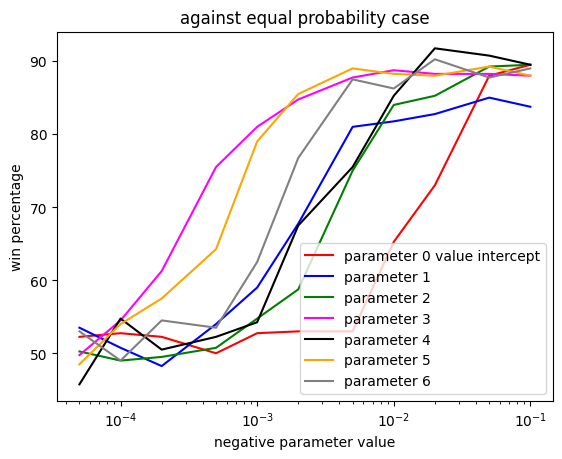

In [49]:
plt.plot(compm[0,:],100*compm[13,:],color='red',label='parameter 0 value intercept') 
plt.plot(compm[0,:],100*compm[14,:],color='blue',label='parameter 1') 
plt.plot(compm[0,:],100*compm[15,:],color='green',label='parameter 2') 
plt.plot(compm[0,:],100*compm[16,:],color='magenta',label='parameter 3') 
plt.plot(compm[0,:],100*compm[17,:],color='black',label='parameter 4')  
plt.plot(compm[0,:],100*compm[18,:],color='orange',label='parameter 5')  
plt.plot(compm[0,:],100*compm[19,:],color='gray',label='parameter 6') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("negative parameter value")
plt.ylabel("win percentage")
plt.title("against equal probability case")

Basic procedure. Find a good enough alternative, add it to the models. Then fit try some more slect the once which performs best in average. For now Monte Carlo. Use above plots for finding range to be explored. 

In [64]:
#does Monte carlo against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_ranges and discard_ranges are 2,6 np arrays, value_ranges is 2,7 np array, 
#reliazations are number of models tried in one, trials are number of MC models for level 21
def montecarlo_trials(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials):
    n_it=realizations
    results=np.zeros((40,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing Monte Carlo {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        for k in range(7):
            level21_value_variable[k]=value_ranges[0,k]+random.random()*(value_ranges[1,k]-value_ranges[0,k])
            if k<6:
                level21_open_variable[k]=open_ranges[0,k]+random.random()*(open_ranges[1,k]-open_ranges[0,k])
                level21_discard_variable[k]=discard_ranges[0,k]+random.random()*(discard_ranges[1,k]-discard_ranges[0,k])
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            print(np.round(level21_open_variable,5),np.round(level21_discard_variable,5),np.round(level21_value_variable,5))
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            start_time=time.time()
            for i in range(n_it):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            results[38,j,k]=n_it
            results[39,j,k]=win20
            stop_time=time.time()
            print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[39,j,:])*100/n_it,1)} %")   
    return results 

Now testing the function.

In [66]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0))]
list_discard=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0))]
list_value=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0))]


res=montecarlo_trials(list_open,list_discard,list_value,op_range,dis_range,val_range,50,4)
np.save("mc_v3.npy",res)

doing Monte Carlo 0 for level 21
trying case 0 for level 20
[ 0.03735  0.00259 -0.0449   0.04208  0.05166 -0.06411] [-0.08639  0.07618  0.00618  0.09806 -0.08944 -0.00033] [ 0.0654  -0.07952 -0.04004  0.02084 -0.06365 -0.02544 -0.09467]
50 games need 1.344 seconds
level 20 won to 94.0 %
trying case 1 for level 20
[ 0.03735  0.00259 -0.0449   0.04208  0.05166 -0.06411] [-0.08639  0.07618  0.00618  0.09806 -0.08944 -0.00033] [ 0.0654  -0.07952 -0.04004  0.02084 -0.06365 -0.02544 -0.09467]
50 games need 1.378 seconds
level 20 won to 96.0 %
trying case 2 for level 20
[ 0.03735  0.00259 -0.0449   0.04208  0.05166 -0.06411] [-0.08639  0.07618  0.00618  0.09806 -0.08944 -0.00033] [ 0.0654  -0.07952 -0.04004  0.02084 -0.06365 -0.02544 -0.09467]
50 games need 1.519 seconds
level 20 won to 92.0 %
trying case 3 for level 20
[ 0.03735  0.00259 -0.0449   0.04208  0.05166 -0.06411] [-0.08639  0.07618  0.00618  0.09806 -0.08944 -0.00033] [ 0.0654  -0.07952 -0.04004  0.02084 -0.06365 -0.02544 -0.09467

Text(0, 0.5, 'win percentage')

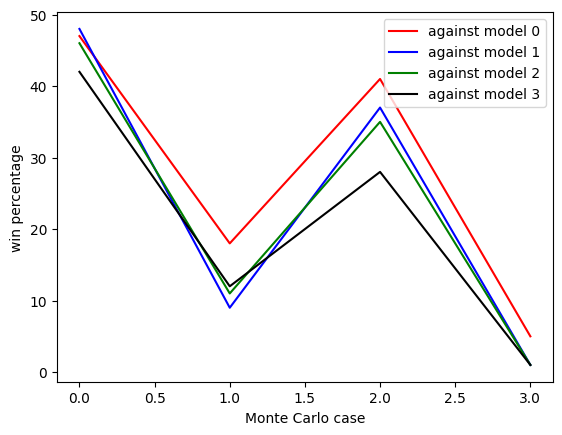

In [71]:
res=np.load("mc_v2.npy")
plt.plot(range(4),res[39,:,0],color='red',label='against model 0') 
plt.plot(range(4),res[39,:,1],color='blue',label='against model 1') 
plt.plot(range(4),res[39,:,2],color='green',label='against model 2') 
plt.plot(range(4),res[39,:,3],color='black',label='against model 3') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("Monte Carlo case")
plt.ylabel("win percentage")

Rather easy to improve compared to the current models. Print results for human trial. 

In [81]:
print(res[19:25,3,2])
print(res[25:31,3,2])
print(res[31:38,3,2])

[ 0.01940094  0.05146526 -0.02648223 -0.07416882 -0.00188127 -0.01222425]
[ 0.07948311  0.05037697  0.00790461 -0.03574202  0.01697387 -0.05714196]
[-0.05759114  0.07014045 -0.05425065  0.09631128 -0.06878424 -0.00164203
  0.08420359]


Change function that it stops early if win fraction is small enough. 

In [89]:
#does Monte carlo against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_ranges and discard_ranges are 2,6 np arrays, value_ranges is 2,7 np array, 
#reliazations are number of models tried in one, trials are number of MC models for level 21
#wfrac when it aborts early 
def montecarlo_trials2(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials,wfrac=0.10):
    n_it=realizations
    results=np.zeros((40,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing Monte Carlo {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        for k in range(7):
            level21_value_variable[k]=value_ranges[0,k]+random.random()*(value_ranges[1,k]-value_ranges[0,k])
            if k<6:
                level21_open_variable[k]=open_ranges[0,k]+random.random()*(open_ranges[1,k]-open_ranges[0,k])
                level21_discard_variable[k]=discard_ranges[0,k]+random.random()*(discard_ranges[1,k]-discard_ranges[0,k])
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            print(np.round(level21_open_variable,5),np.round(level21_discard_variable,5),np.round(level21_value_variable,5))
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            start_time=time.time()
            for i in range(n_it):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            results[38,j,k]=n_it
            results[39,j,k]=win20
            stop_time=time.time()
            print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[39,j,:])*100/n_it,1)} %") 
        if np.mean(results[39,j,:])/n_it<wfrac:
            print("good model found, aborts early")
            if j==0:
                return results[:,j,:]
            else:
                return results[:,0:j,:]
    print("no good model found")    
    return results 

In [90]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0))]
list_discard=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0))]
list_value=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0))]


res=montecarlo_trials2(list_open,list_discard,list_value,op_range,dis_range,val_range,50,4,wfrac=0.5)
np.save("mc_v4.npy",res)

doing Monte Carlo 0 for level 21
trying case 0 for level 20
[ 0.0917   0.09092  0.02911 -0.0644   0.02484  0.03422] [ 0.05066 -0.03289 -0.07856 -0.04399 -0.0389   0.08049] [ 0.09695 -0.03195 -0.02561  0.02458  0.09049 -0.06819  0.05431]
50 games need 3.093 seconds
level 20 won to 92.0 %
trying case 1 for level 20
[ 0.0917   0.09092  0.02911 -0.0644   0.02484  0.03422] [ 0.05066 -0.03289 -0.07856 -0.04399 -0.0389   0.08049] [ 0.09695 -0.03195 -0.02561  0.02458  0.09049 -0.06819  0.05431]
50 games need 2.15 seconds
level 20 won to 86.0 %
trying case 2 for level 20
[ 0.0917   0.09092  0.02911 -0.0644   0.02484  0.03422] [ 0.05066 -0.03289 -0.07856 -0.04399 -0.0389   0.08049] [ 0.09695 -0.03195 -0.02561  0.02458  0.09049 -0.06819  0.05431]
50 games need 1.942 seconds
level 20 won to 66.0 %
trying case 3 for level 20
[ 0.0917   0.09092  0.02911 -0.0644   0.02484  0.03422] [ 0.05066 -0.03289 -0.07856 -0.04399 -0.0389   0.08049] [ 0.09695 -0.03195 -0.02561  0.02458  0.09049 -0.06819  0.05431]

In [91]:
print(res.shape)

(3, 4)


In [88]:
print(res)

[]
